In [33]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet("s3://ling583/wine-test.parquet", storage_options={"anon": True})

In [3]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [4]:
sgd = cloudpickle.load(open("sgd.model", "rb"))
sgd

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.79, min_df=2,
                                 preprocessor=<cyfunction identity at 0x7f6c61c9e2b0>,
                                 tokenizer=<function tokenize at 0x7f6bf8c0e160>)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier(alpha=1.507610100544865e-05))])

In [5]:
# reprinting report for easy reference to confusion matrices further below

predicted = sgd.predict(test["review_text"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.82      0.75      7558
        Chardonnay       0.83      0.85      0.84      4861
            Merlot       0.84      0.33      0.48      1381
        Pinot Noir       0.76      0.88      0.81      9618
          Riesling       0.81      0.79      0.80      2421
   Sauvignon Blanc       0.85      0.66      0.74      1278
             Syrah       0.76      0.53      0.63      3426
         Zinfandel       0.87      0.51      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.80      0.67      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [8]:
import matplotlib.pyplot as plt

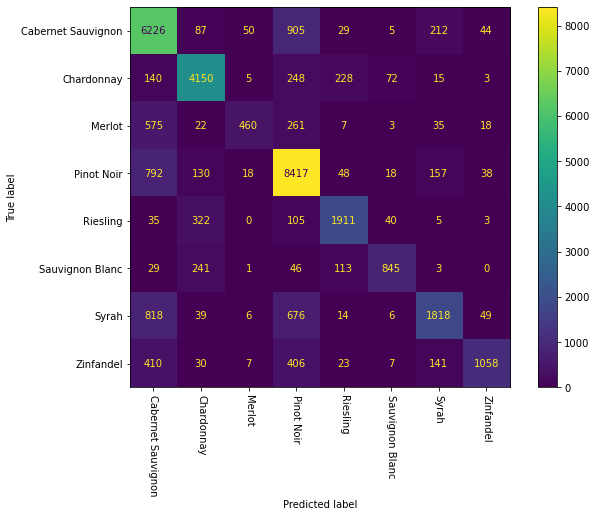

In [28]:
# confusion matrix of actual numbers/amounts for true and predicted labels
fig,ax=plt.subplots(figsize=(10,7))
plot_confusion_matrix(sgd, test["review_text"], test["wine_variant"], xticks_rotation=-90,ax=ax)

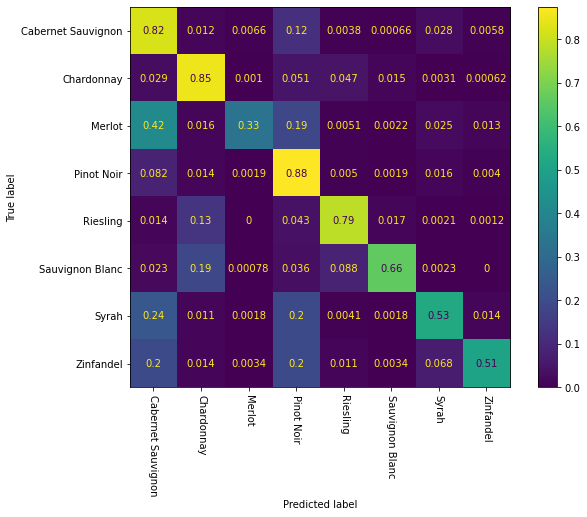

In [29]:
# confusion matrix of normalized values (proportions according to rows/true labels)

fig,ax=plt.subplots(figsize=(10,7))
plot_confusion_matrix(sgd, test["review_text"], test["wine_variant"], xticks_rotation=-90,normalize='true',ax=ax)

In our model, of all the true Merlot labels based on classified review texts, approximately 42% were incorrectly labeled as Cabernet Sauvignon. Likewise, of all the true Syrah labels based on review texts, approximately 24% were incorrectly labeled as Cabernet Sauvignon.

For now, merlot will be the top priority for label adjusting.

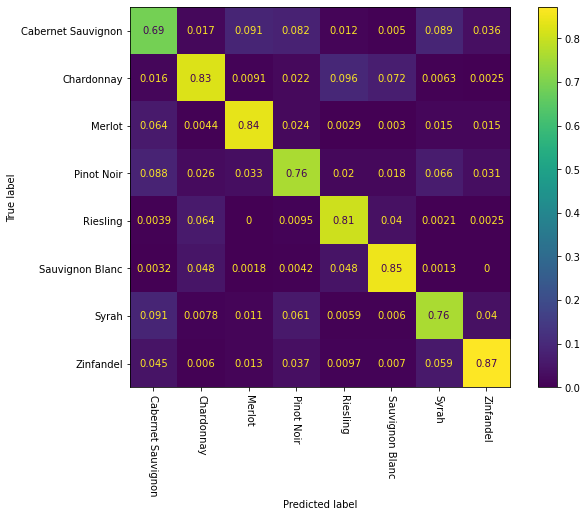

In [39]:
# confusion matrix of normalized values (proportions according to columns/predicted labels)
fig,ax=plt.subplots(figsize=(10,7))
plot_confusion_matrix(sgd, test["review_text"], test["wine_variant"], xticks_rotation=-90,normalize='pred',ax=ax)

Generally, our labels here are not as much of a cause for concern. It could be said that, of all the classified review text labeled as Riesling, approximately 9.6% of them were actually Chardonnay. Similarly, of all the review text labeled as Merlot, approximately 9.1% were actually Cabernet Sauvignon.

In [37]:
train_copy=train.copy()
test_copy=test.copy()

In [40]:
m1=train_copy['wine_variant'].isin(['Merlot','Cabernet Sauvignon'])
train_copy['wine_variant']=train_copy['wine_variant'].mask(m1,'Merlot/Cab. Sauvignon')

In [44]:
train_copy['wine_variant'].value_counts()

Pinot Noir               38471
Merlot/Cab. Sauvignon    35756
Chardonnay               19443
Syrah                    13704
Riesling                  9683
Zinfandel                 8327
Sauvignon Blanc           5113
Name: wine_variant, dtype: int64

In [45]:
n1=test_copy['wine_variant'].isin(['Merlot','Cabernet Sauvignon'])
test_copy['wine_variant']=test_copy['wine_variant'].mask(n1,'Merlot/Cab. Sauvignon')

In [47]:
#trying with my classifier trained on a different set of labels

sgd.fit(train_copy["review_text"], train_copy["wine_variant"])
predicted = sgd.predict(test_copy["review_text"])
print(classification_report(test_copy["wine_variant"], predicted))

                       precision    recall  f1-score   support

           Chardonnay       0.83      0.86      0.84      4861
Merlot/Cab. Sauvignon       0.74      0.86      0.79      8939
           Pinot Noir       0.79      0.85      0.82      9618
             Riesling       0.82      0.78      0.80      2421
      Sauvignon Blanc       0.85      0.65      0.74      1278
                Syrah       0.76      0.52      0.62      3426
            Zinfandel       0.88      0.51      0.64      2082

             accuracy                           0.78     32625
            macro avg       0.81      0.72      0.75     32625
         weighted avg       0.79      0.78      0.78     32625



As it is, this changed label already increases the macro-average F1 score of my model by .04, which was done through training my classifier (with hyperparameters found in notebook 1) on a 'consolidated' merlot+cabernet sauvignon label. I believe it's possible for the F1 score to still improve from here with this classifier, though it may require many different label adjustments beyond consolidating two of them into one category.